# Insurance Modeling Problem

Problem: Develop and compare six different machine learning regression models to predict clients’ insurance charges: 
1. Perform an EDA; 
2. Preprocess the data;
3. Build the models;
4. Explain the outputs.

In [35]:
# Import baseic
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor

from ray.tune.sklearn import TuneGridSearchCV
from sklearn.model_selection import GridSearchCV

In [36]:
%matplotlib inline

In [37]:
URL = "https://open-data.s3.filebase.com/insurance.csv"

In [38]:
data = pd.read_csv(URL)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [40]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [41]:
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [42]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [43]:
numerical = ['age', 'bmi', 'children', 'charges']
categorical = ['smoker', 'region', 'sex']

data = data[categorical+numerical]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   smoker    1338 non-null   object 
 1   region    1338 non-null   object 
 2   sex       1338 non-null   object 
 3   age       1338 non-null   int64  
 4   bmi       1338 non-null   float64
 5   children  1338 non-null   int64  
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

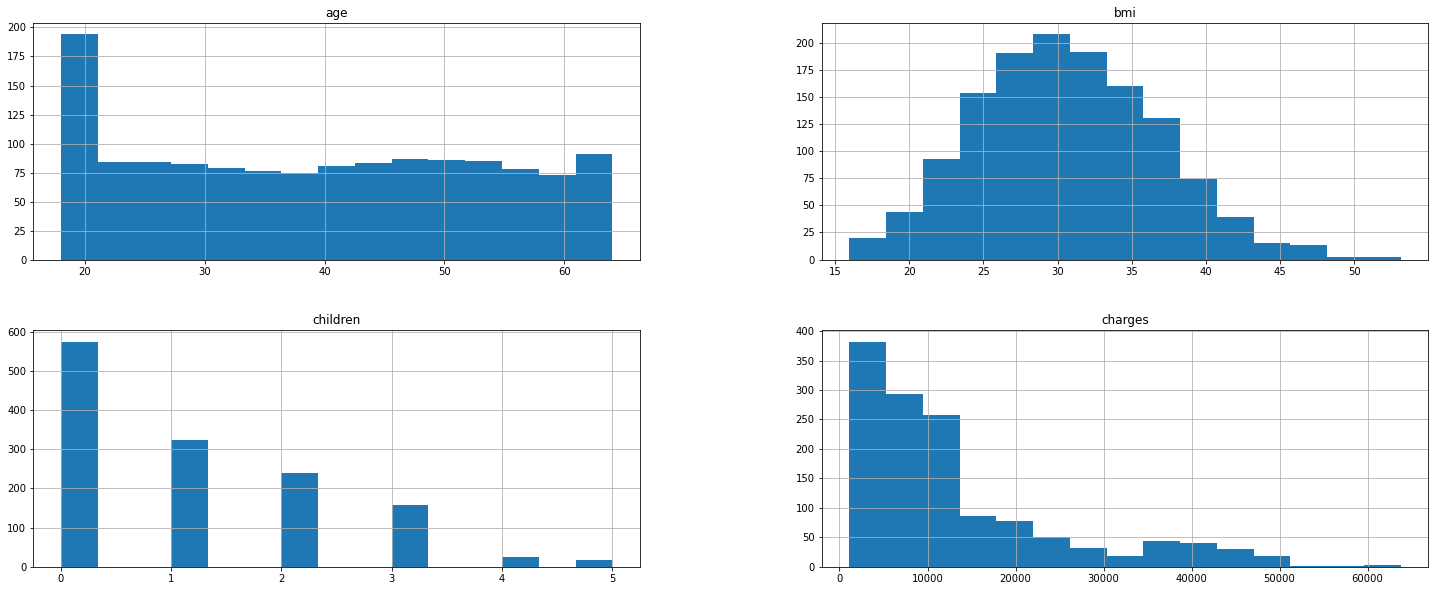

In [44]:
data[numerical].hist(bins=15, figsize=(25, 10), layout=(2, 2))

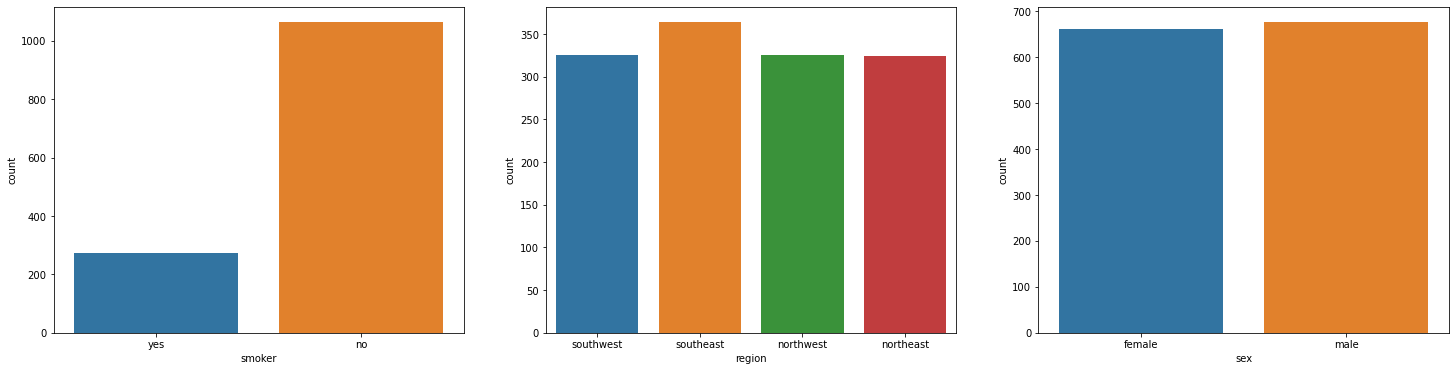

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(x=data[variable], ax=subplot)

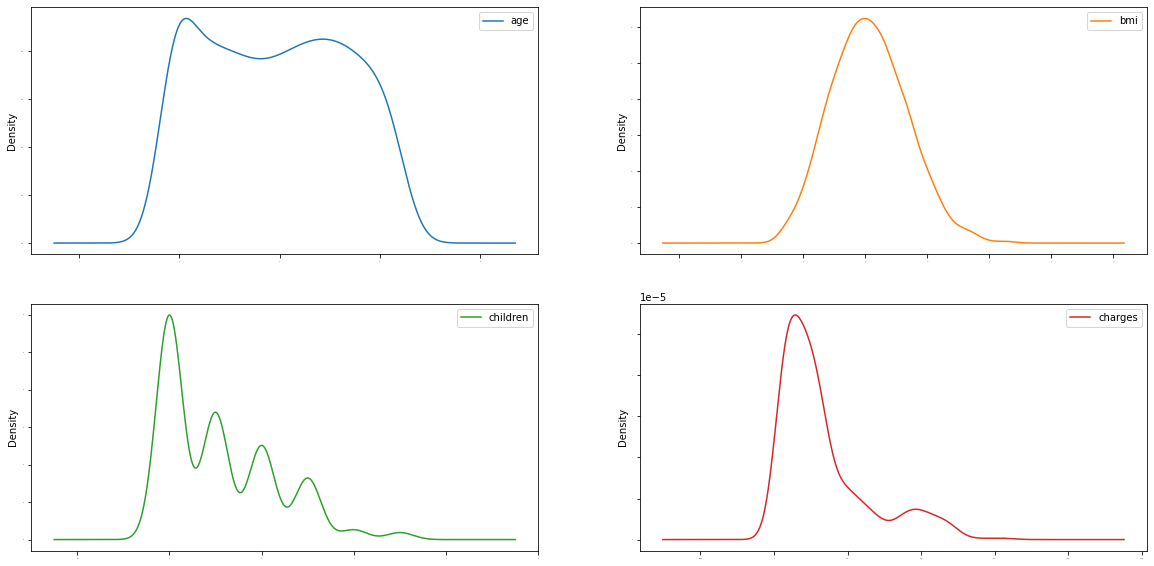

In [46]:
data.plot(kind='density', subplots=True, layout=(2,2), sharex=False, legend=True, fontsize=1, figsize=(20,10))
plt.show()

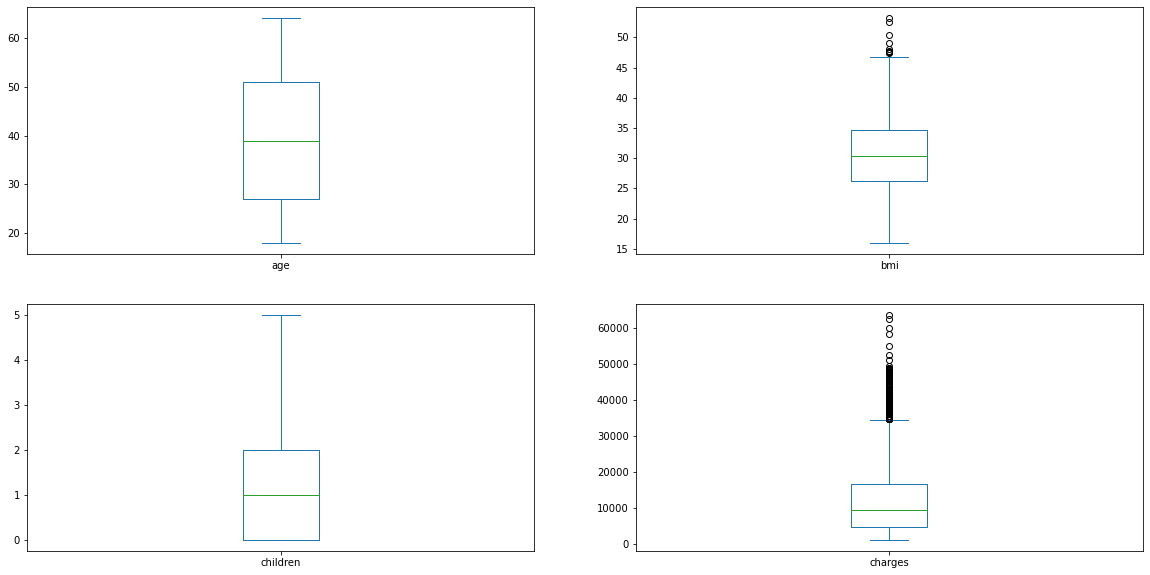

In [47]:
data.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(20,10))
plt.show()

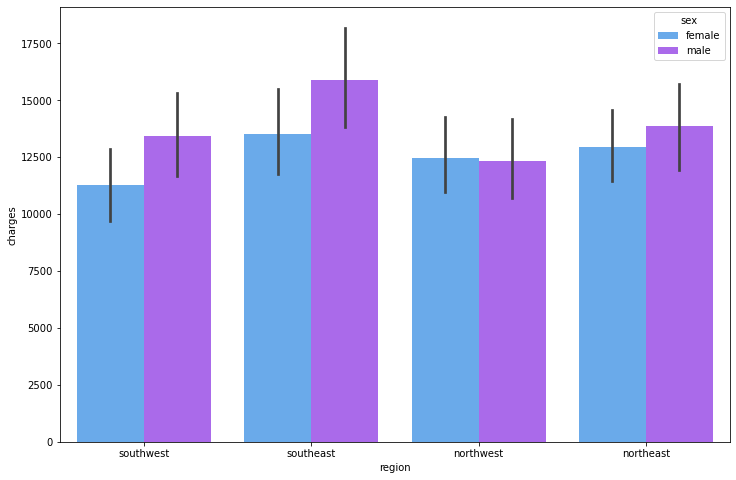

In [48]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=data, palette='cool')

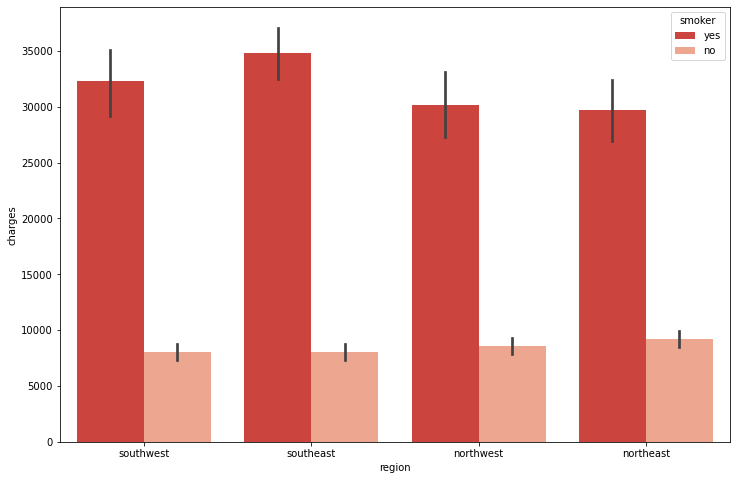

In [49]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=data, palette='Reds_r')

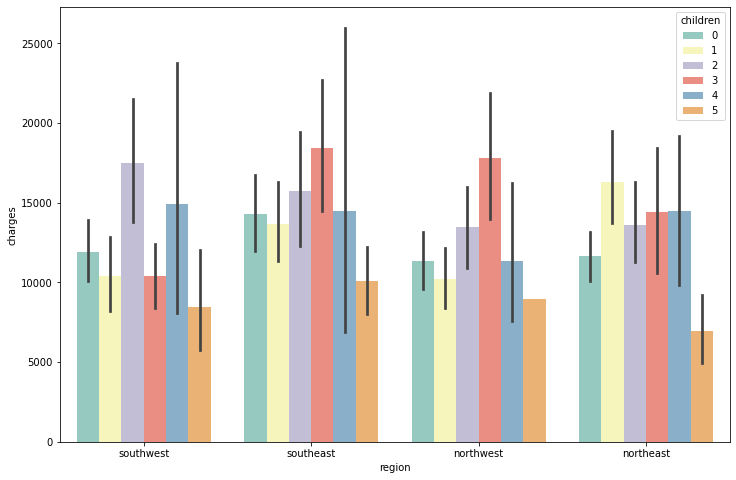

In [50]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=data, palette='Set3')

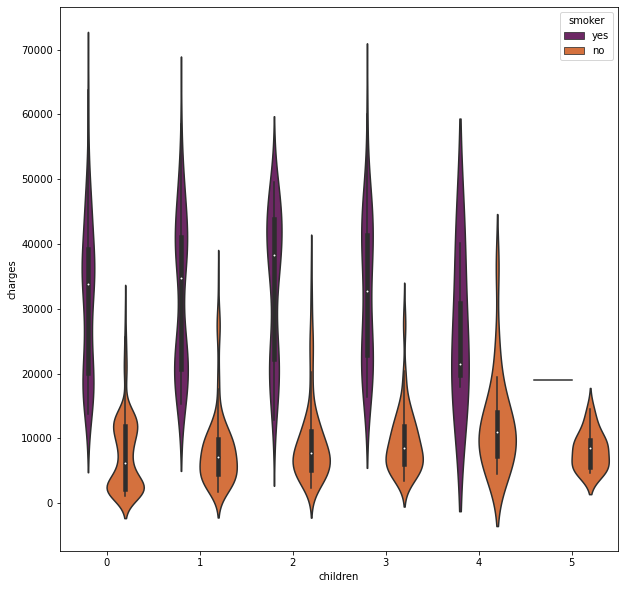

In [51]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=data, orient='v', hue='smoker', palette='inferno')

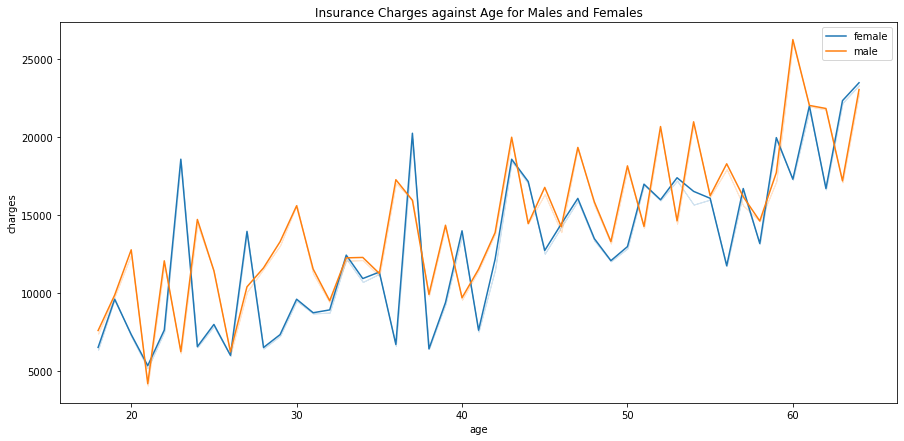

In [52]:
plt.figure(figsize=(15,7))
sns.lineplot(x=data["age"], y=data["charges"], hue=data["sex"], ci=0).set(title= 'Insurance Charges against Age for Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

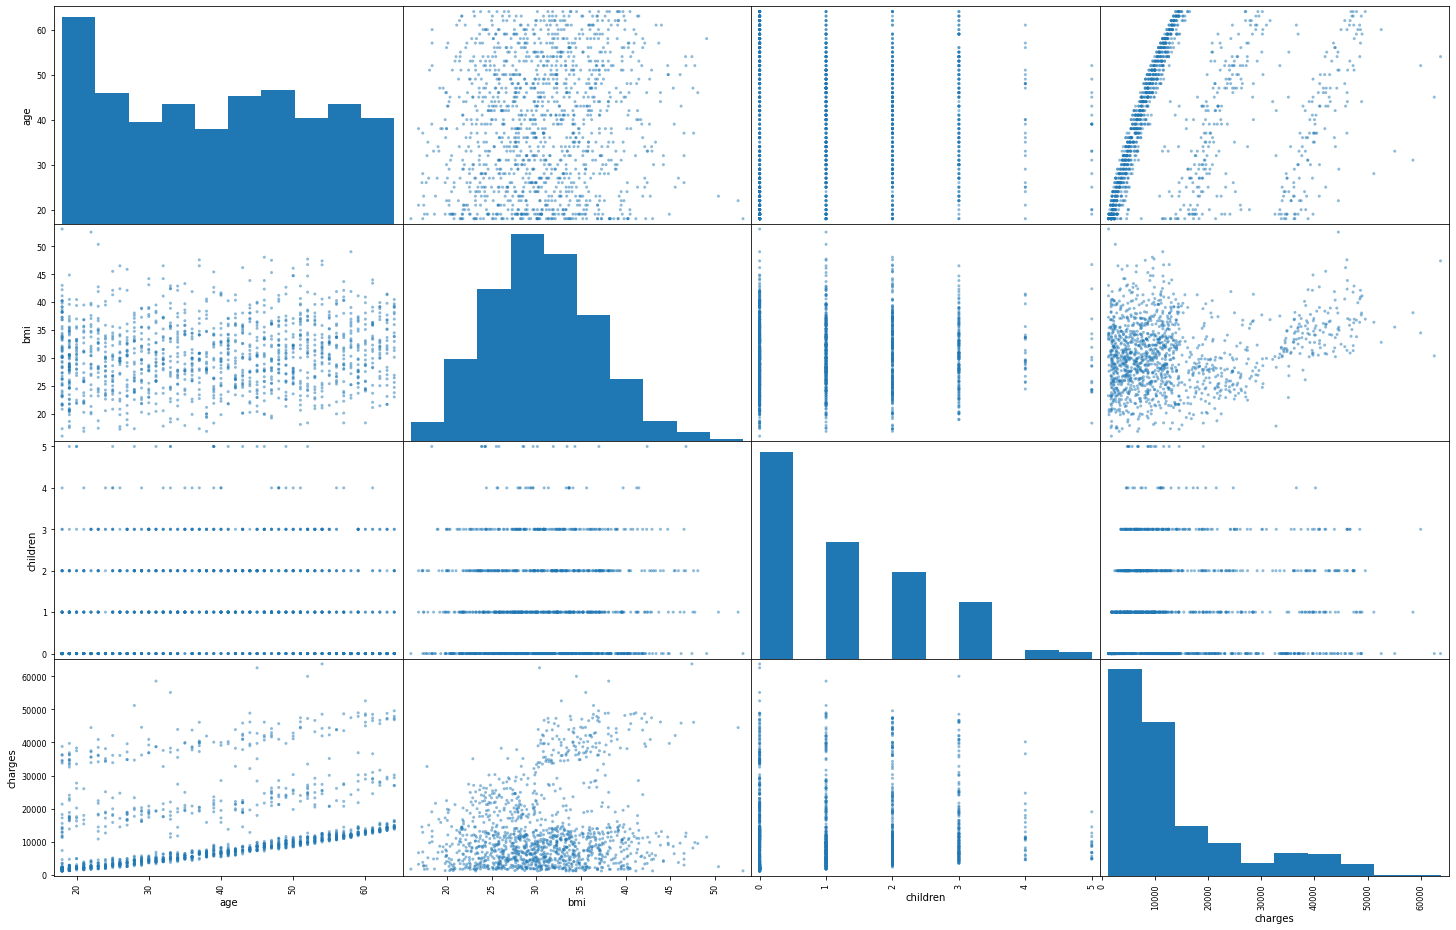

In [53]:
scatter_matrix(data,figsize=(25,16))
plt.show()

In [54]:
data[['sex', 'smoker', 'region']] = data[['sex', 'smoker', 'region']].astype('category')
label = LabelEncoder()

for variable in categorical:
    label.fit(data[variable].drop_duplicates())
    data[variable] = label.transform(data[variable])

data.dtypes

smoker        int32
region        int32
sex           int32
age           int64
bmi         float64
children      int64
charges     float64
dtype: object

In [55]:
data['charges'] = np.log(data['charges'])

<AxesSubplot:title={'center':'Correlation Matrix'}>

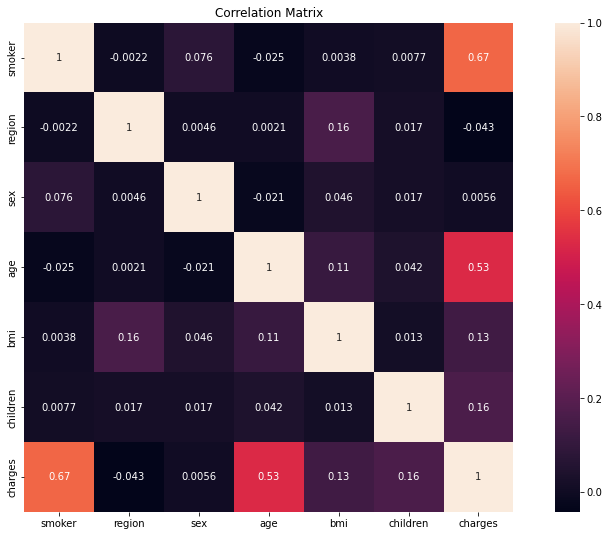

In [56]:
correlation = data.corr()
plt.figure(figsize=(15,9))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True)

In [57]:
data.head()

,smoker,region,sex,age,bmi,children,charges
0,1,3,0,19,27.900,0,9.734176
1,0,2,1,18,33.770,1,7.453302
2,0,2,1,28,33.000,3,8.400538
3,0,1,1,33,22.705,0,9.998092
4,0,1,1,32,28.880,0,8.260197


In [58]:
X = data.drop(['charges'], axis=1).values
y = data['charges'].values

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
transformation = MinMaxScaler()
X_train = transformation.fit_transform(X_train)
X_test = transformation.fit_transform(X_test)

In [60]:
reg = LinearRegression()
reg.fit(X_train, y_train)

print("Score the X-train with Y-train is : ", reg.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", reg.score(X_test,y_test))

Score the X-train with Y-train is :  0.7635007324334577
Score the X-test  with Y-test  is :  0.7766373089068213


In [61]:
dtr = DecisionTreeRegressor(criterion='squared_error',splitter='best',random_state=42)
dtr.fit(X_train, y_train)

print("Score the X-train with Y-train is : ", dtr.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", dtr.score(X_test,y_test))

y_pred = dtr.predict(X_test)
print("MSE: " , mean_squared_error(np.log(y_test),np.log(y_pred)))

Score the X-train with Y-train is :  0.9969342543253151
Score the X-test  with Y-test  is :  0.6714282051202726
MSE:  0.0034759441636276036


In [62]:
rfr = RandomForestRegressor(n_estimators=100,random_state=42)
rfr.fit(X_train,y_train)


print("Score the X-train with Y-train is : ", rfr.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", rfr.score(X_test,y_test))

y_pred = rfr.predict(X_test)
print("MSE: " ,mean_squared_error(np.log(y_test),np.log(y_pred)))

Score the X-train with Y-train is :  0.9719571324338614
Score the X-test  with Y-test  is :  0.8075518499640348
MSE:  0.0020864480617647715


In [63]:
xgb=XGBRegressor(random_state=42)

xgb.fit(X_train,y_train)

print("Score the X-train with Y-train is : ", xgb.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", xgb.score(X_test,y_test))

Score the X-train with Y-train is :  0.9921098073039096
Score the X-test  with Y-test  is :  0.8037506182897857


In [64]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train,y_train)

print("Score the X-train with Y-train is : ", gbr.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", gbr.score(X_test,y_test))

y_pred = gbr.predict(X_test)
print("MSE: " ,mean_squared_error(np.log(y_test),np.log(y_pred)))

Score the X-train with Y-train is :  0.8926895534209652
Score the X-test  with Y-test  is :  0.8349346706843193
MSE:  0.001769987517844089


In [65]:
cat = CatBoostRegressor(iterations = 1000, learning_rate = 0.075, depth = 3, loss_function = 'RMSE', eval_metric = 'RMSE', random_seed = 560,
                        od_type = 'Iter', metric_period = 50, od_wait = 10, task_type="GPU", devices='0:1')

cat.fit(X_train,y_train, eval_set=(X_test, y_test), verbose = False)

print("Score the X-train with Y-train is : ", cat.score(X_train,y_train))
print("Score the X-test  with Y-test  is : ", cat.score(X_test,y_test))

Score the X-train with Y-train is :  0.8564518612873829
Score the X-test  with Y-test  is :  0.8345843366421734


In [66]:
param_grid = gbr.get_params(deep=True)
param_grid = {key:[value] for key, value in param_grid.items()}
param_grid.pop('n_estimators')

tune_search = TuneGridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42, warm_start=True),
    param_grid = param_grid,
    n_jobs=4,
    max_iters=50,
    early_stopping=True
    )

tune_search.fit(X_train, y_train)

#best set of perameter
print(tune_search.best_params_)

#best score with best set of perameters
print(tune_search.best_score)

(pid=25824) Windows fatal exception: access violation
(pid=25824) 


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False, 'n_estimators': 50}
0.8258063719752942


In [68]:
param_grid = gbr.get_params(deep=True)
param_grid = {key:[value] for key, value in param_grid.items()}

g_search = GridSearchCV(estimator = gbr, param_grid = param_grid,cv = 3, n_jobs = 1,verbose = True, return_train_score=True)
g_search.fit(X_train, y_train);

print(g_search.best_params_)
print(g_search.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
0.8358319152286077


End of Notebook